In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MalwareCNN(nn.Module):
    def __init__(self, num_classes):
        super(MalwareCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers
        self.dropout0_2 = nn.Dropout(0.2)
        self.dropout0_5 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = None
        self.fc2 = None
        self.fc3 = nn.Linear(256, num_classes)  # This will be adjusted dynamically

    def forward(self, x):
        # Convolutional Block 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout0_2(x)
        
        # Convolutional Block 2
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout0_5(x)
        
        # Convolutional Block 3
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output from conv layers
        x = x.view(x.size(0), -1)  # Dynamic flattening

        # If fc1 and fc2 are not defined, we need to create them based on the input size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 512)  # Set input size dynamically based on flattened size
        if self.fc2 is None:
            self.fc2 = nn.Linear(512, 256)  # Set input size dynamically based on previous layer size
            
        # Fully Connected Block
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout0_5(x)
        x = self.fc3(x)
        
        return x
# Example usage
num_classes = 25  # Set this based on the number of malware classes
model = MalwareCNN(num_classes).to("cuda")
print(model)

MalwareCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout0_2): Dropout(p=0.2, inplace=False)
  (dropout0_5): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=25, bias=True)
)


In [2]:
print(device)

cuda


In [3]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
#train_dataset = datasets.ImageFolder(root='malimg_dataset/malimg_paper_dataset_imgs', transform=transform)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Path to the main directory containing subdirectories for each class
main_dir = 'malimg_dataset/malimg_paper_dataset_imgs'

# Extract class names from subdirectory names
class_names = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Print class names
print("Class Names:", class_names)

# Load the dataset
dataset = datasets.ImageFolder(root=main_dir, transform=transform)

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now you have both train_loader and test_loader

Class Names: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


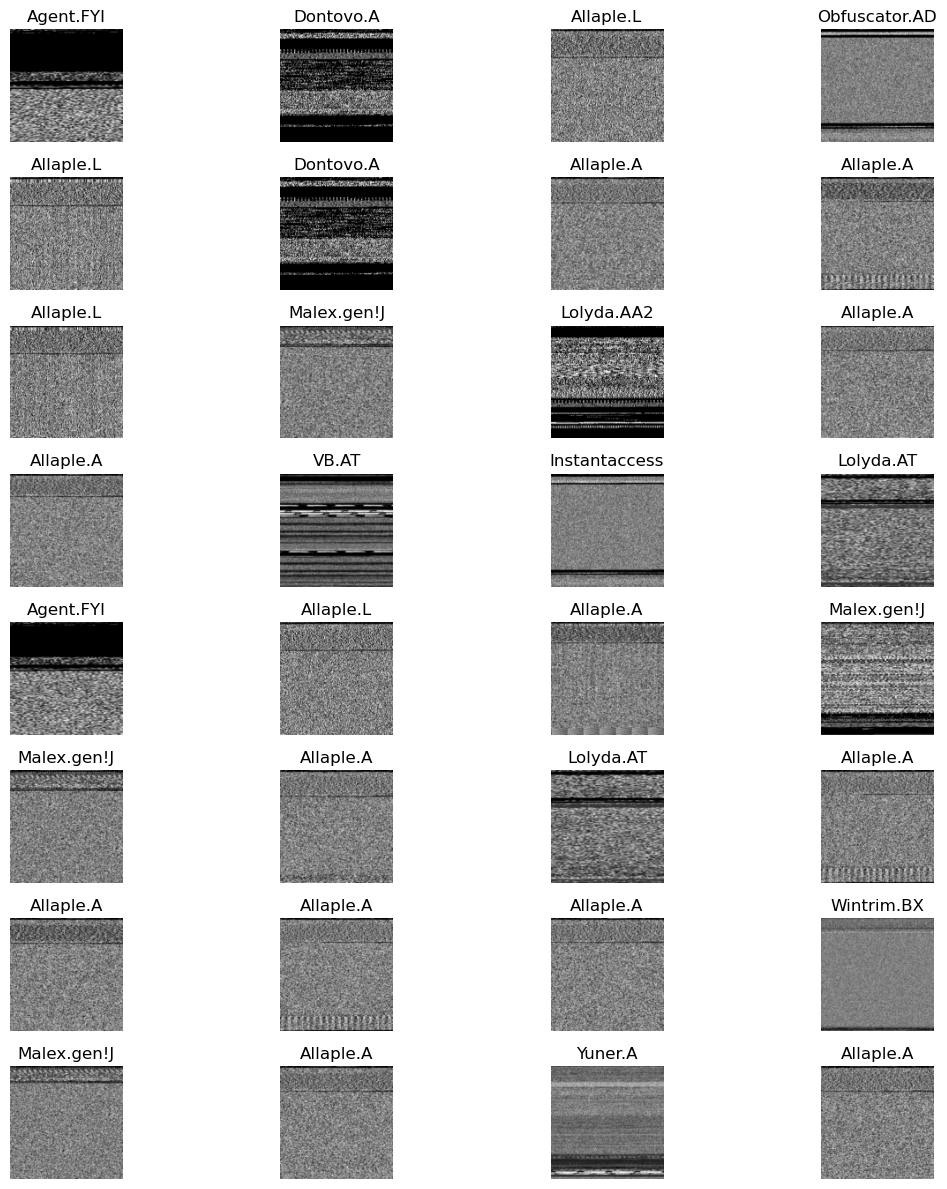

In [4]:
import matplotlib.pyplot as plt

examples = next(iter(train_loader))
images, labels = examples

# Normalize the image data to the range [0, 1]
images = (images - images.min()) / (images.max() - images.min())

fig, axes = plt.subplots(8, 4, figsize=(12, 12))
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"{class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
model.to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
                
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.1302
Epoch [2/10], Loss: 0.1256
Epoch [3/10], Loss: 0.1309
Epoch [4/10], Loss: 0.0226
Epoch [5/10], Loss: 0.0286
Epoch [6/10], Loss: 0.0400
Epoch [7/10], Loss: 0.2275
Epoch [8/10], Loss: 0.0468
Epoch [9/10], Loss: 0.1896
Epoch [10/10], Loss: 0.0095


In [11]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print(f'{method.__name__}: {(te - ts) * 1000} ms')
        return result
    return timed

@timeit
def get_predictions(model, dataloader):
    model = model.to("cuda")
    # Set the model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []
    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # Get the index of the maximum value
            _, preds = torch.max(outputs, 1)
            # Append the predictions and labels to the respective lists
            all_preds.append(preds)
            all_labels.append(labels)
    # Return the lists of predictions and labels
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    return all_preds, all_labels

In [12]:
y_pred_list, y_true_list = get_predictions(model, train_loader)
y_pred_list

get_predictions: 13945.180416107178 ms


array([ 6,  2,  2, ...,  3, 18,  3], dtype=int64)

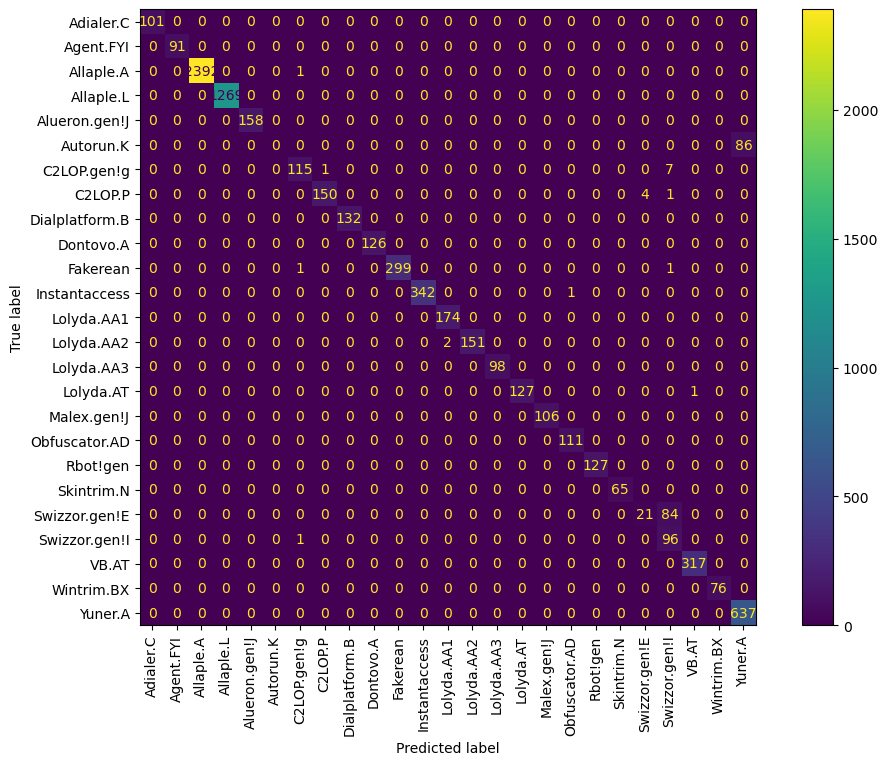

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_list, y_pred_list)

fig, ax = plt.subplots(figsize=(12,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

The majority of malwares are well classified, with the exception of **Autorun.K**